# Курсовой проект для курса "Python для Data Science" 

##  Описание датасета
* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

### Подключение библиотек и скриптов

In [28]:
import numpy as np
import pandas as pd
import random

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [29]:
matplotlib.rcParams.update({'font.size': 14})

In [30]:
def evaluate_preds(true_values, pred_values):
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)))
        
    plt.figure(figsize=(10,10))
    
    sns.scatterplot(x=pred_values, y=true_values)
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()

### Пути к директориям и файлам

In [31]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
PREDICTIONS_PATH = 'Bogacheva_Anna_predictions.csv'

### Загрузка данных

In [32]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

### Обзор обучающего датасета train и тестового датасета test

In [33]:
print(f"Train:\t{train.shape[0]}\t sales and {train.shape[1]} features")
print(f'Test:\t{test.shape[0]}\t sales and {test.shape[1]} features')

Train:	10000	 sales and 20 features
Test:	5000	 sales and 19 features


In [34]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

In [35]:
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

In [36]:
# убираем признак 'id', т.к не несет важной информации
train['DistrictId'] = train['DistrictId'].astype(str)
train = train.drop('Id', axis =1 )

In [37]:
test['DistrictId'] = test['DistrictId'].astype(str)
test = test.drop('Id', axis =1 )

In [38]:
train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962


In [39]:
test.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [40]:
train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [41]:
test.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


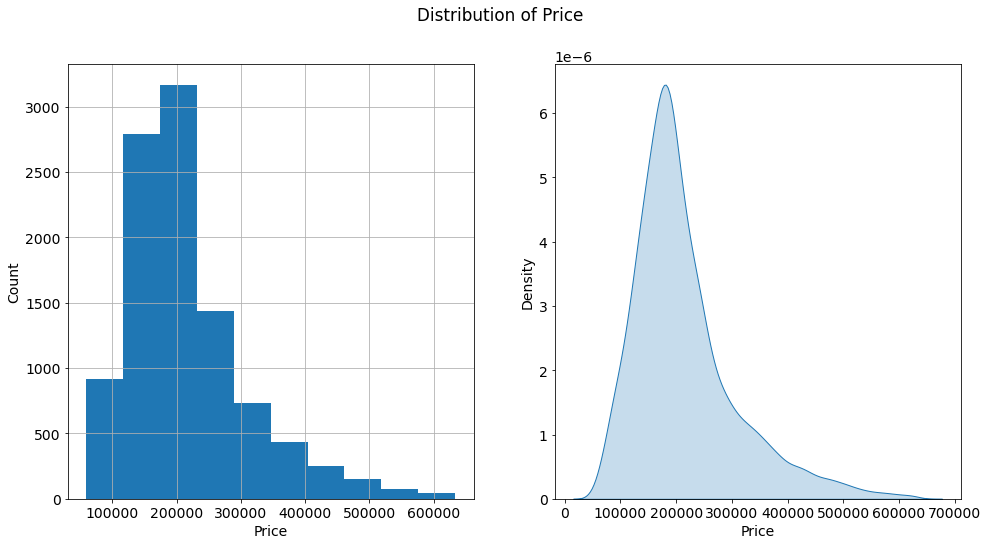

In [42]:
plt.figure(figsize = (16, 8))

plt.subplot(121)
train['Price'].hist()
plt.ylabel('Count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

### Подготовка обучающего датасета train

In [43]:
# Исключаем признак "Healthcare_1", т.к. по нему почти 50% пропусков
train = train.drop('Healthcare_1', axis=1)

In [45]:
# Преобразуем категориальные признаки "Ecology_2", "Ecology_3", "Shops_2" в бинарные
print(train['Ecology_2'].value_counts())
print(train['Ecology_3'].value_counts())
print(train['Shops_2'].value_counts())

B    9903
A      97
Name: Ecology_2, dtype: int64
B    9725
A     275
Name: Ecology_3, dtype: int64
B    9175
A     825
Name: Shops_2, dtype: int64


In [46]:
train['Ecology_2_bin'] = train['Ecology_2'].replace({'A':0, 'B':1})
train['Ecology_3_bin'] = train['Ecology_3'].replace({'A':0, 'B':1})
train['Shops_2_bin'] = train['Shops_2'].replace({'A':0, 'B':1})

In [47]:
# Работаем с выбросами признака "Rooms"
rooms_med = train['Rooms'].median()
train.loc[train['Rooms'].isin([0, 10, 19]), 'Rooms'] = rooms_med

In [48]:
# Работаем с выбросами признаков "LifeSquare" и "KitchenSquare"
lifesq_med = train['LifeSquare'].median()
kitchsq_med = train['KitchenSquare'].median()
train.loc[train['LifeSquare'].isnull(), 'LifeSquare'] = lifesq_med
train.loc[train['LifeSquare'] < 10, 'LifeSquare'] = lifesq_med
train.loc[train['LifeSquare'] > 400, 'LifeSquare'] = lifesq_med
train.loc[train['KitchenSquare'] < 5, 'KitchenSquare'] = kitchsq_med
train.loc[train['KitchenSquare'] > 80, 'KitchenSquare'] = kitchsq_med

In [49]:
# Работаем с выбросами признака "Square"
square_med = train['Square'].median()
train.loc[train['Square'] < 16, 'Square'] = square_med
train.loc[train['Square'] > 400, 'Square'] = square_med

In [50]:
# Работаем с выбросами признака "HouseYear"
train.loc[train['HouseYear'] > 2020, 'HouseYear'] = 2020

In [51]:
# Работаем с выбросами признаков "Floor" и "HouseFloor"
hfloor_med = train['HouseFloor'].median()
train.loc[train['HouseFloor'] == 0, 'HouseFloor'] = hfloor_med

ind = train[train['Floor'] > train['HouseFloor']].index
train.loc[ind, 'Floor'] = train.loc[ind, 'HouseFloor']

In [52]:
# Вычисляем "m_2_Price" - стоимость квадратного метра общей площади
train['m_2_Price'] = train['Price'] / train['Square']

In [53]:
# На его основе создаем новые признаки m_2_MedPriceByDistrict - медианная стоимость квадратного метра в зависимости от района 
# и m_2_MedPriceByHouseYear - медианная стоимость квадратного метра в зависимости от возраста дома
m_2_MedPriceByDistrict = train.groupby(['DistrictId'], as_index=False).agg({'m_2_Price':'median'})\
                    .rename(columns={'m_2_Price':'m_2_MedPriceByDistrict'})
m_2_MedPriceByHouseYear = train.groupby(['HouseYear'], as_index=False).agg({'m_2_Price':'median'})\
                    .rename(columns={'m_2_Price':'m_2_MedPriceByHouseYear'})

In [54]:
# Добавляем новые признаки к датасету
train = train.merge(m_2_MedPriceByDistrict, on=['DistrictId'], how='left')
train = train.merge(m_2_MedPriceByHouseYear, on=['HouseYear'], how='left')
train.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_Price,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear
0,27,3.0,115.027311,32.781260,10.0,4.0,10.0,2014,0.075424,B,...,0,0,B,305018.871089,1,1,1,2651.708272,2759.086353,2793.739365
1,22,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,0.118537,B,...,1,0,B,177734.553407,1,1,1,4462.045990,3553.678687,4376.488083
2,1,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,0.025609,B,...,3,1,B,282078.720850,1,1,1,3600.596698,3251.647396,4447.681698
3,1,1.0,40.409907,32.781260,6.0,10.0,22.0,1977,0.007122,B,...,0,1,B,168106.007630,1,1,1,4160.019670,3251.647396,2901.326376
4,94,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,0.282798,B,...,0,6,B,343995.102962,1,1,1,5351.088794,4219.992382,4285.794408


In [55]:
train.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_Price,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.888800,56.228457,35.980607,7.490600,7.918200,12.95910,1984.872400,0.118858,24.687000,5352.157400,8.039200,1.319500,4.231300,214138.857399,0.990300,0.972500,0.917500,3891.739716,3927.295723,3780.144330
std,0.812096,19.058793,15.378518,3.290409,5.186386,6.44346,18.416347,0.119025,17.532614,4006.799803,23.831875,1.493601,4.806341,92872.293865,0.098015,0.163543,0.275139,1251.728243,997.479341,762.735269
min,1.000000,16.117154,10.523868,5.000000,1.000000,1.00000,1910.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,59174.778028,0.000000,0.000000,0.000000,752.588644,2273.498737,2764.147132
25%,1.000000,41.800063,27.654813,6.000000,4.000000,9.00000,1974.000000,0.017647,6.000000,1564.000000,0.000000,0.000000,1.000000,153872.633942,1.000000,1.000000,1.000000,2916.973642,2938.048239,2901.326376
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.00000,1977.000000,0.075424,25.000000,5285.000000,2.000000,1.000000,3.000000,192269.644879,1.000000,1.000000,1.000000,3907.999942,4134.353749,4285.794408
75%,2.000000,65.889736,41.415441,9.000000,11.000000,17.00000,2001.000000,0.195781,36.000000,7227.000000,5.000000,2.000000,6.000000,249135.462171,1.000000,1.000000,1.000000,4690.526670,4562.026777,4409.376396
max,6.000000,275.645284,263.542020,78.000000,42.000000,117.00000,2020.000000,0.521867,74.000000,19083.000000,141.000000,6.000000,23.000000,633233.466570,1.000000,1.000000,1.000000,11854.652892,8700.768533,7823.822055


In [56]:
len(train) - train.count()

DistrictId                 0
Rooms                      0
Square                     0
LifeSquare                 0
KitchenSquare              0
Floor                      0
HouseFloor                 0
HouseYear                  0
Ecology_1                  0
Ecology_2                  0
Ecology_3                  0
Social_1                   0
Social_2                   0
Social_3                   0
Helthcare_2                0
Shops_1                    0
Shops_2                    0
Price                      0
Ecology_2_bin              0
Ecology_3_bin              0
Shops_2_bin                0
m_2_Price                  0
m_2_MedPriceByDistrict     0
m_2_MedPriceByHouseYear    0
dtype: int64

### Отбираем признаки для модели

In [57]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear', 
                 'm_2_MedPriceByDistrict', 'm_2_MedPriceByHouseYear', 
                 'Ecology_1','Social_1', 'Social_3', 'Helthcare_2', 'Shops_1', 
                 'Ecology_2_bin', 'Ecology_3_bin', 'Shops_2_bin',]
target_name = 'Price'

In [58]:
df = train[feature_names + [target_name]]
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
0,3.0,115.027311,32.781260,10.0,4.0,10.0,2014,2759.086353,2793.739365,0.075424,11,0,0,0,1,1,1,305018.871089
1,1.0,39.832524,23.169223,8.0,7.0,8.0,1966,3553.678687,4376.488083,0.118537,30,1,1,0,1,1,1,177734.553407
2,3.0,78.342215,47.671972,10.0,2.0,17.0,1988,3251.647396,4447.681698,0.025609,33,0,3,1,1,1,1,282078.720850
3,1.0,40.409907,32.781260,6.0,10.0,22.0,1977,3251.647396,2901.326376,0.007122,1,0,0,1,1,1,1,168106.007630
4,2.0,64.285067,38.562517,9.0,16.0,16.0,1972,4219.992382,4285.794408,0.282798,33,2,0,6,1,1,1,343995.102962


### Масштабируем признаки

In [59]:
scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names])

In [60]:
df[feature_names] = pd.DataFrame(stand_features, columns=feature_names)
df.head()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear,Ecology_1,Social_1,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,Price
0,1.368379,3.085284,-0.208050,0.762679,-0.755516,-0.459264,1.581696,-1.171220,-1.293311,-0.364931,-0.780698,-0.337347,-0.883480,-0.880402,0.09897,0.16816,0.299864,305018.871089
1,-1.094506,-0.860325,-0.833112,0.154821,-0.177049,-0.769672,-1.024815,-0.374580,0.781888,-0.002690,0.303050,-0.295384,-0.213923,-0.880402,0.09897,0.16816,0.299864,177734.553407
2,1.368379,1.160350,0.760278,0.762679,-1.141160,0.627163,0.169836,-0.677390,0.875233,-0.783473,0.474169,-0.337347,1.125190,-0.672333,0.09897,0.16816,0.299864,282078.720850
3,-1.094506,-0.830028,-0.208050,-0.453036,0.401417,1.403183,-0.427489,-0.677390,-1.152250,-0.938799,-1.351093,-0.337347,-0.883480,-0.672333,0.09897,0.16816,0.299864,168106.007630
4,0.136936,0.422745,0.167899,0.458750,1.558350,0.471959,-0.699001,0.293451,0.662976,1.377425,0.474169,-0.253421,-0.883480,0.368011,0.09897,0.16816,0.299864,343995.102962


### Разбиваем на обучающую и валидационную выборку

In [72]:
X = df[feature_names]
y = df[target_name]
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.3, shuffle=True, random_state=21)

### Строим и обучаем модель

In [73]:
# Используем GradientBoostingRegressor
gb_model = GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=21)
gb_model.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=5, n_estimators=200, random_state=21)

R2:	0.954


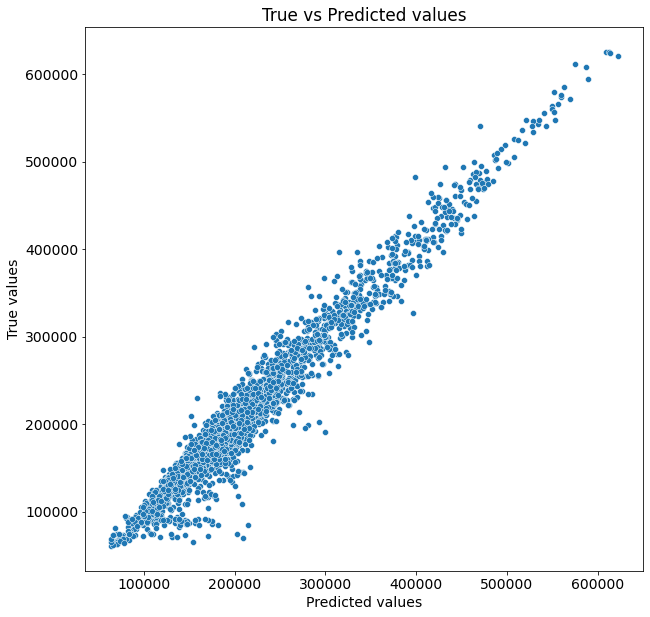

In [74]:
y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

### Проверка на валидационной выборке

R2:	0.74


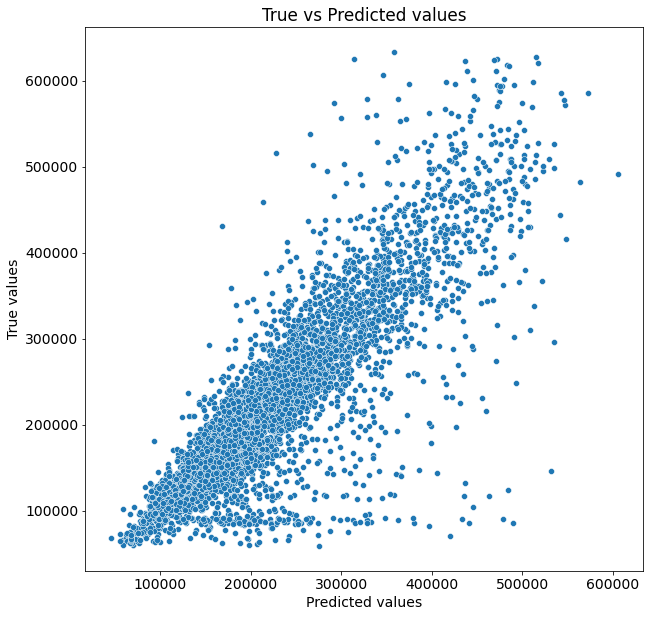

In [80]:
y_valid_preds = gb_model.predict(X_valid)
evaluate_preds(y_valid, y_valid_preds)

### Все тоже самое, но с использованием RandomForestRegressor

In [75]:
# Используем RandomForestRegressor
forest = RandomForestRegressor()
forest.fit(X_train, y_train)

RandomForestRegressor()

R2:	0.962


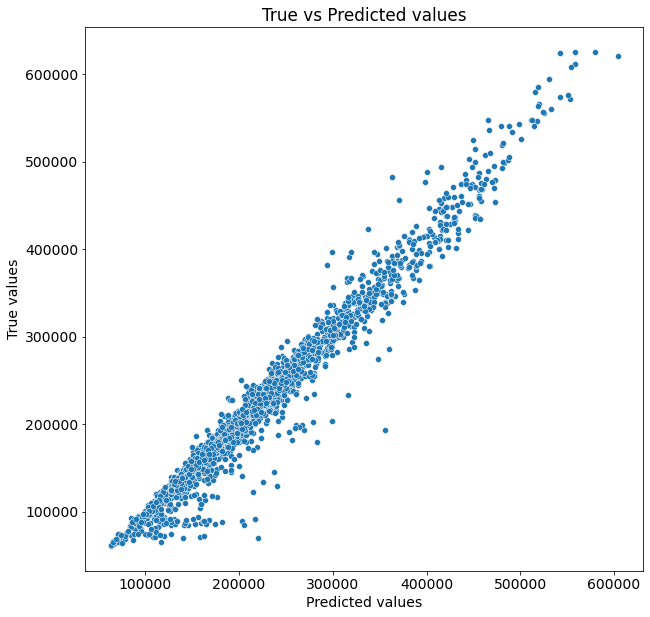

R2:	0.741


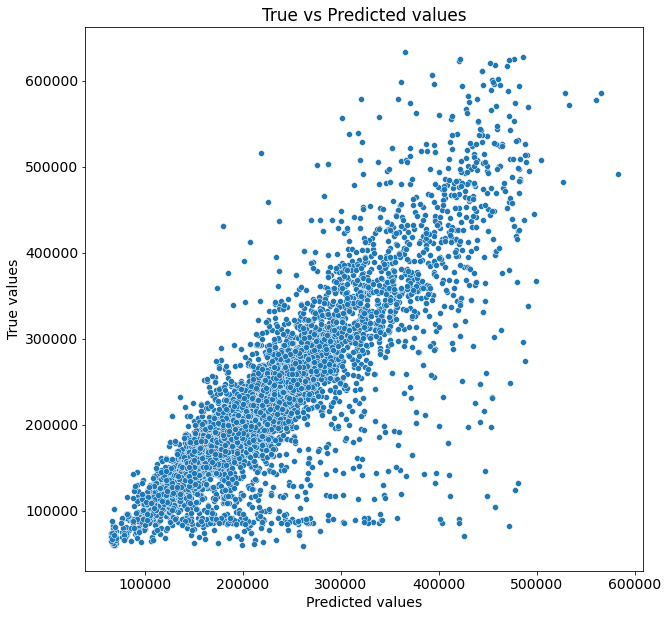

In [79]:
train_pred = forest.predict(X_train)
test_pred = forest.predict(X_valid)
evaluate_preds(y_train, train_pred)
evaluate_preds(y_valid, test_pred)

### Важность признаков

In [81]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.435992
7,m_2_MedPriceByDistrict,0.359690
8,m_2_MedPriceByHouseYear,0.039453
10,Social_1,0.027135
2,LifeSquare,0.023376
6,HouseYear,0.017634
0,Rooms,0.017424
5,HouseFloor,0.015824
9,Ecology_1,0.013530
11,Social_3,0.012782


### Подготовка тестового датасета test

In [82]:
# Исключаем признак "Healthcare_1", т.к. по нему почти 50% пропусков
test = test.drop('Healthcare_1', axis=1)

In [83]:
# Преобразуем категориальные признаки "Ecology_2", "Ecology_3", "Shops_2" в бинарные
print(test['Ecology_2'].value_counts())
print(test['Ecology_3'].value_counts())
print(test['Shops_2'].value_counts())

B    4952
A      48
Name: Ecology_2, dtype: int64
B    4851
A     149
Name: Ecology_3, dtype: int64
B    4588
A     412
Name: Shops_2, dtype: int64


In [84]:
test['Ecology_2_bin'] = test['Ecology_2'].replace({'A':0, 'B':1})
test['Ecology_3_bin'] = test['Ecology_3'].replace({'A':0, 'B':1})
test['Shops_2_bin'] = test['Shops_2'].replace({'A':0, 'B':1})

In [85]:
# Работаем с выбросами признака "Rooms"
test.loc[test['Rooms'].isin([0, 17]), 'Rooms'] = rooms_med

In [86]:
# Работаем с выбросами признаков "LifeSquare" и "KitchenSquare"
test.loc[test['LifeSquare'].isnull(), 'LifeSquare'] = lifesq_med
test.loc[test['LifeSquare'] < 10, 'LifeSquare'] = lifesq_med
test.loc[test['LifeSquare'] > 200, 'LifeSquare'] = lifesq_med
test.loc[test['KitchenSquare'] < 5, 'KitchenSquare'] = kitchsq_med
test.loc[test['KitchenSquare'] > 80, 'KitchenSquare'] = kitchsq_med

In [87]:
# Работаем с выбросами признака "Square"
test.loc[test['Square'] < 16, 'Square'] = square_med
test.loc[test['Square'] > 400, 'Square'] = square_med

In [88]:
# Работаем с выбросами признаков "Floor" и "HouseFloor"
test.loc[test['HouseFloor'] == 0, 'HouseFloor'] = hfloor_med

In [89]:
ind = test[test['Floor'] > test['HouseFloor']].index
test.loc[ind, 'Floor'] = test.loc[ind, 'HouseFloor']

In [90]:
# Добавляем новые признаки к датасету
test = test.merge(m_2_MedPriceByDistrict, on=['DistrictId'], how='left')
test = test.merge(m_2_MedPriceByHouseYear, on=['HouseYear'], how='left')

In [91]:
# Заполняем возможные пропуски
test.loc[test['m_2_MedPriceByDistrict'].isnull(), 'm_2_MedPriceByDistrict'] =\
                    m_2_MedPriceByDistrict['m_2_MedPriceByDistrict'].median()

In [92]:
test.loc[(test['m_2_MedPriceByHouseYear'].isnull()) & (test['HouseYear'] < 1950), 
                     'm_2_MedPriceByHouseYear'] =\
                      m_2_MedPriceByHouseYear.loc[m_2_MedPriceByHouseYear['HouseYear'] < 1950,
                                                  'm_2_MedPriceByHouseYear'].median()

In [93]:
test.loc[(test['m_2_MedPriceByHouseYear'].isnull()) & (test['HouseYear'] >= 1990), 
                     'm_2_MedPriceByHouseYear'] =\
                      m_2_MedPriceByHouseYear.loc[m_2_MedPriceByHouseYear['HouseYear'] >= 1990,
                                                  'm_2_MedPriceByHouseYear'].median()

In [94]:
test.loc[(test['m_2_MedPriceByHouseYear'].isnull()) & (test['HouseYear'] >= 1950) &\
                    (test['HouseYear'] < 1990), 'm_2_MedPriceByHouseYear'] =\
                      m_2_MedPriceByHouseYear.loc[(m_2_MedPriceByHouseYear['HouseYear'] >= 1950) & \
                                                  (m_2_MedPriceByHouseYear['HouseYear'] < 1990),
                                                  'm_2_MedPriceByHouseYear'].median()

In [95]:
test.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,m_2_MedPriceByDistrict,m_2_MedPriceByHouseYear
count,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.90780,56.543749,36.047463,7.425800,8.054000,12.941600,1984.392600,0.119874,24.933800,5406.900000,8.262600,1.31940,4.242800,0.990400,0.970200,0.917600,3946.750805,3790.421605
std,0.81008,18.955344,14.706864,3.038674,5.337076,6.466881,18.573149,0.120070,17.532202,4026.614773,23.863762,1.47994,4.777365,0.097518,0.170052,0.275001,985.494228,761.818482
min,1.00000,16.319015,10.692499,5.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,2273.498737,2793.739365
25%,1.00000,41.951045,27.990919,6.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,2949.975415,2901.326376
50%,2.00000,52.921340,32.781260,6.000000,7.000000,13.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,1.00000,3.000000,1.000000,1.000000,1.000000,4158.187979,4285.794408
75%,2.00000,66.285129,41.760597,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,2.00000,6.000000,1.000000,1.000000,1.000000,4571.660177,4409.376396
max,6.00000,223.453689,169.901701,65.000000,46.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,6.00000,23.000000,1.000000,1.000000,1.000000,8700.768533,7823.822055


In [96]:
len(test) - test.count()

DistrictId                 0
Rooms                      0
Square                     0
LifeSquare                 0
KitchenSquare              0
Floor                      0
HouseFloor                 0
HouseYear                  0
Ecology_1                  0
Ecology_2                  0
Ecology_3                  0
Social_1                   0
Social_2                   0
Social_3                   0
Helthcare_2                0
Shops_1                    0
Shops_2                    0
Ecology_2_bin              0
Ecology_3_bin              0
Shops_2_bin                0
m_2_MedPriceByDistrict     0
m_2_MedPriceByHouseYear    0
dtype: int64

### Масштабируем признаки

In [97]:
stand_features = scaler.fit_transform(test[feature_names])

In [98]:
test[feature_names] = pd.DataFrame(stand_features, columns=feature_names)

### Предсказываем цены для тестового датасета

In [100]:
X_test = test[feature_names]

In [102]:
y_test_preds = gb_model.predict(X_test)
y_test_preds

array([173809.66908259, 120369.31486616, 148323.87661184, ...,
       150681.71826907, 190644.80742573, 247402.16607467])

### Сохраняем результаты

In [104]:
test_df['Price'] = y_test_preds

In [105]:
test_df.to_csv(PREDICTIONS_PATH, columns=['Id', 'Price'], index=False, encoding='utf-8')